In [1]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = torch.device('cuda')

from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
clear_output()

import utils
import data_extraction as da
import extract_sem_representation as esr

import modelling as md
import plotting

test_size = 0.1
# TODO: create graph showing experiments with pooling strategies

[nltk_data] Downloading package stopwords to /home/raine-
[nltk_data]     bianchini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/raine-
[nltk_data]     bianchini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
cat_cols = ['themes', 'violence', 'drug_use', 'sex']

df = pd.read_parquet(da.cleaned_dataset_fp).drop(columns=['nudity', 'language']).sort_values(['movie', 'start_time'])

for col in cat_cols:
    df[col] = md.convert_col_to_ordinal(df[col])
    
ratings = df[cat_cols + ['movie']].drop_duplicates().drop(columns=['movie']).values

In [36]:
from sklearn import svm

In [56]:
[ii for ii, x in enumerate(rep_list) if x.reshape(-1).shape[0] != 393216]

[68, 80, 247, 256]

In [57]:
rep_list[68].reshape(-1).shape[0]

24576

In [64]:
df.movie.unique()[256]

'The Hunger Games Mockingjay   Part 2'

In [53]:
preds = []

for pooling_model_name in md.pooling_models:
    for rep_type in ['dialogue', 'transcript']:
        for packing_type in ('chunks', 'utterances'):
            for pooling_strat in ['lhs2CLS']:
                rep_list = esr.get_or_create_movie_sem_reps(df, pooling_model_name, rep_type, packing_type, pooling_strat, device, use_profiler=False)
                rep_list = [x.reshape(-1) for x in rep_list]
                X = torch.stack(rep_list).cpu().numpy().astype(np.float16)
                X[X == np.inf] = np.finfo(np.float16).max
                X[X == -np.inf] = np.finfo(np.float16).min
                X_train, X_test, y_train, y_test = train_test_split(X, np.array(ratings)[:, 0], test_size=test_size, random_state=42)

                # TODO: try alternatives like SVM?
                # FIXME: handle SBERT differently (maybe just SVM)
                basic_svc_model = svm.SVC()
                # basic_log_model = MultiOutputClassifier(LogisticRegression(max_iter=10000))
                basic_svc_model.fit(X_train, y_train)
                y_pred = basic_svc_model.predict(X_test)
                preds.append({'model': pooling_model_name, 'rep_type': rep_type, 'packing_type': packing_type, 'pooling_strat': pooling_strat, 'preds': y_pred})
            
clear_output()

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
Some weights of the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 were not used when initializing BertModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertF

RuntimeError: stack expects each tensor to be equal size, but got [393216] at entry 0 and [24576] at entry 68

In [26]:
preds_metrics = [{key: value for key, value in row_dict.items()} for row_dict in preds]

for row in preds_metrics:
    row['acc'] = accuracy_score(y_test.reshape(-1), row['preds'].reshape(-1))
    row['f1_macro'] = f1_score(y_test.reshape(-1), row['preds'].reshape(-1), average='macro')
    del row['preds']

In [30]:
len(models_masks)

7

In [33]:
preds_metrics_df = pd.DataFrame(preds_metrics)
models_masks = [preds_metrics_df['model'].eq(name) for name in md.pooling_models[:-1]]

preds_metrics_df['abb_model_name'] = np.select(
    models_masks,
    ['cardiff-multilabel', 'cardiff-binary', 'cardif-sentiment', 'emotions', 'imdb-sentiment', 'modernBERT'],
    default='Error'
)
preds_metrics_df['cat'] = preds_metrics_df['rep_type'] + ', ' + preds_metrics_df['packing_type']

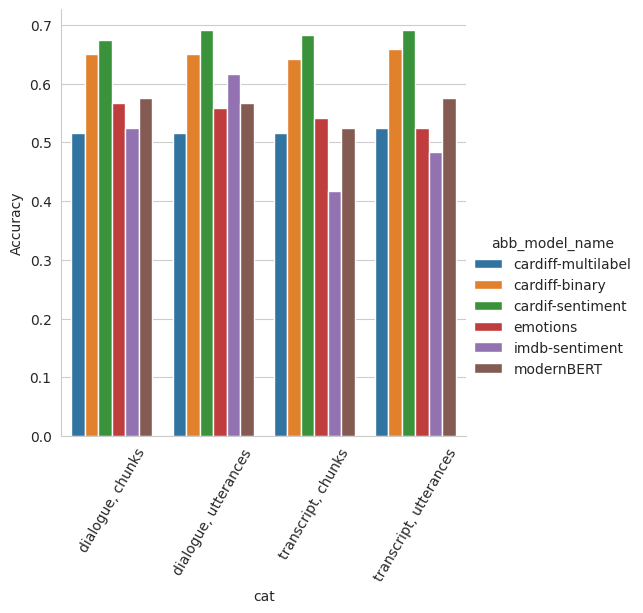

In [34]:
g = sns.catplot(
    data=preds_metrics_df, kind='bar',
    x='cat', y='acc', hue='abb_model_name',
)
plt.ylabel('Accuracy')
g.set_xticklabels(rotation=60)
plt.show()

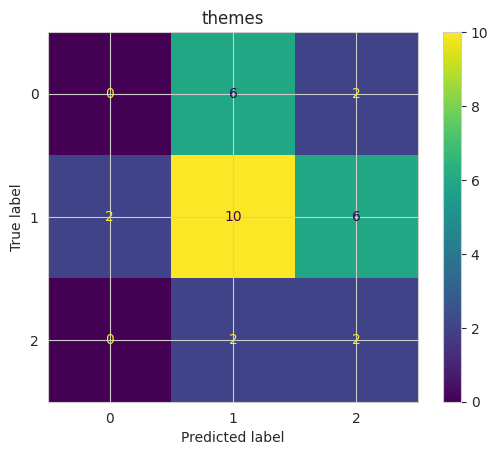

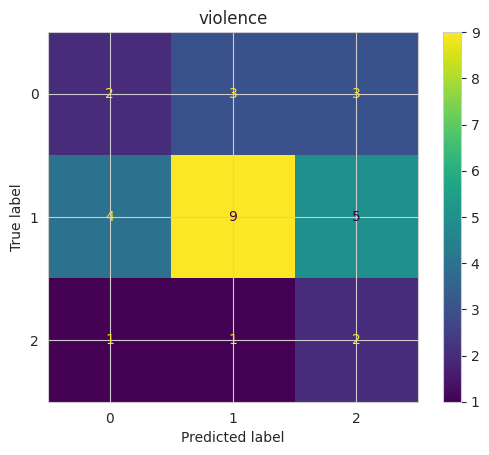

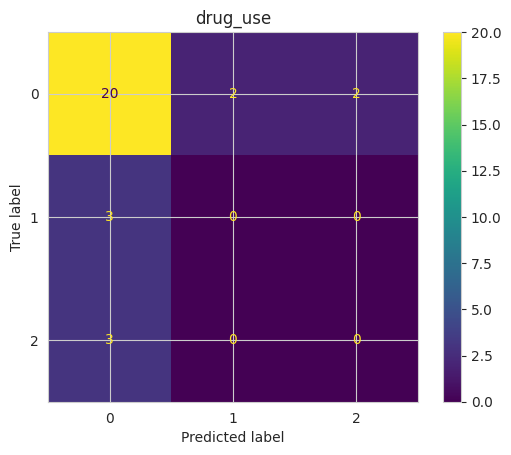

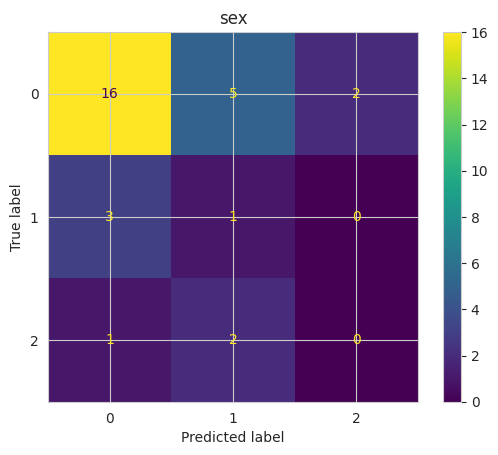

In [35]:
for ii, col in enumerate(md.cat_cols):
    curr_cat_preds = preds[1]['preds'][:, ii]
    curr_cat_true = y_test[:, ii]
    mat = confusion_matrix(curr_cat_true, curr_cat_preds)
    disp = ConfusionMatrixDisplay(mat)
    disp.plot()
    plt.title(col)
    plt.show()